In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.options.display.max_columns = 99

In [2]:
os.chdir('..')  # change to root directory

In [3]:
# Load data
import pickle
from firenet.util import add_uncertainty_features
with open('./data/d_data.pkl', 'rb') as infile:
    d_data = pickle.load(infile)
    
d_data = add_uncertainty_features(d_data)
d_data.keys()

dict_keys(['fullbay', 'fullbayerr', 'shortbay', 'shortbayerr', 'redshift', 'observed', 'observederr', 'obserr_to_short', 'obs_to_short'])

# Single train/test split

In [4]:
from firenet.ml.reguncpredictor import RegUncPredictor

pred = RegUncPredictor(d_data)
pred.preprocess()
pred.train_regressor()

  epoch    train_loss    valid_loss    cp     dur
-------  ------------  ------------  ----  ------
      1        0.8563        0.6324     +  0.1074
      2        0.5462        0.3888     +  0.0937
      3        0.3926        0.3133     +  0.0891
      4        0.3348        0.2798     +  0.0855
      5        0.3058        0.2585     +  0.0849
      6        0.2840        0.2440     +  0.0869
      7        0.2670        0.2325     +  0.0857
      8        0.2537        0.2240     +  0.0897
      9        0.2434        0.2177     +  0.0811
     10        0.2353        0.2126     +  0.0795
     11        0.2286        0.2084     +  0.0847
     12        0.2227        0.2048     +  0.0770
     13        0.2177        0.2018     +  0.0738
     14        0.2130        0.1992     +  0.0815
     15        0.2090        0.1972     +  0.0813
     16        0.2054        0.1953     +  0.0800
     17        0.2021        0.1937     +  0.0757
     18        0.1992        0.1925     +  0.0756


In [5]:
pred.train_uncertainty()

  epoch    train_loss    valid_loss    cp     dur
-------  ------------  ------------  ----  ------
      1      260.6774      -12.6341     +  0.0981
      2     -385.6351     -825.5135     +  0.0806
      3    -1331.2830    -1683.4573     +  0.0739
      4    -2114.8427    -2212.8734     +  0.0749
      5    -2573.1555    -2485.0450     +  0.0790
      6    -2818.7504    -2621.7595     +  0.0799
      7    -2952.4738    -2692.8763     +  0.0803
      8    -3029.6012    -2732.7545     +  0.0825
      9    -3078.4305    -2757.7877     +  0.0765
     10    -3112.0968    -2774.9234     +  0.0780
     11    -3136.9712    -2787.5167     +  0.0793
     12    -3156.1887    -2797.3284     +  0.0768
     13    -3171.4530    -2805.0090     +  0.0886
     14    -3184.0404    -2811.2253     +  0.0886
     15    -3194.6050    -2816.3776     +  0.0869
     16    -3203.6844    -2820.7407     +  0.0901
     17    -3211.6541    -2824.4054     +  0.0854
     18    -3218.5928    -2827.4649     +  0.0807


In [6]:
pred.reg.test()

PACS_70      0.219394
PACS_100     0.190762
PACS_160     0.171650
SPIRE_250    0.183411
SPIRE_350    0.199027
SPIRE_500    0.213302
Name: rmse, dtype: float64

In [7]:
pred.unc.test()

PACS_70      1.087919
PACS_100     1.112869
PACS_160     1.162271
SPIRE_250    1.070298
SPIRE_350    1.014228
SPIRE_500    0.997160
Name: mean_chisq, dtype: float64

In [8]:
y_t, y_p, y_perr = pred.get_target_set()

In [9]:
# Storing and loading models
from firenet.ml.modelstore import ModelStore

ModelStore().store(pred, name='nnet')  # Save to './models/nnet.pkl' by default
pred = ModelStore().load(d_data, name='nnet')  # Load "nnet" model

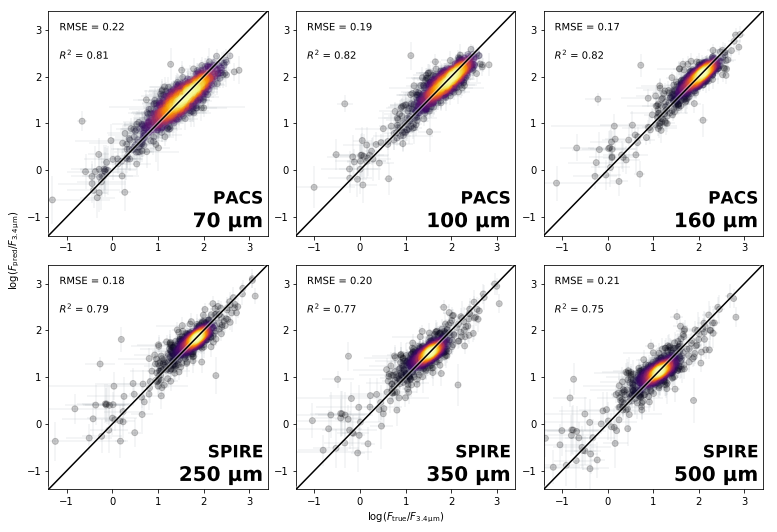

In [10]:
from firenet.plotting.truevspred import TrueVSPredPlotter

firbands = d_data['fullbay'].columns[-6:]
idx = y_t.index
y_terr = d_data['fullbayerr'].loc[idx, firbands].divide(d_data['fullbay'].loc[idx] * np.log(10), axis=0)

tvpplot = TrueVSPredPlotter(figsize=(12.8, 8.8))
tvpplot.create_panels(nrows=1)
panel = tvpplot.get_panel(0)
panel.stylized_plot(y_t, y_p, y_terr=y_terr, y_perr=y_perr, 
                    style='firflux')

# Full set predictor
Using a 4-fold train/test split, training 4 predictors. Each galaxy is used as a test sample once.

In [11]:
from firenet.ml.fullsetpredictor import FullSetPredictor
fspred = FullSetPredictor(d_data)

In [12]:
fspred.prepare_splits(shuffle_state=123)

In [13]:
fspred.train()

Start training model 1/4...
Start training model 2/4...
Start training model 3/4...
Start training model 4/4...


In [14]:
# Storing and loading models
from firenet.ml.modelstore import ModelStore

ModelStore().store(fspred, name='fsnnet')  # Save to './models/fsnnet.pkl' by default
fspred = ModelStore().load(d_data, name='fsnnet')  # Load "fsnnet" model

In [15]:
y_t, y_p, y_perr = fspred.get_combined_test()

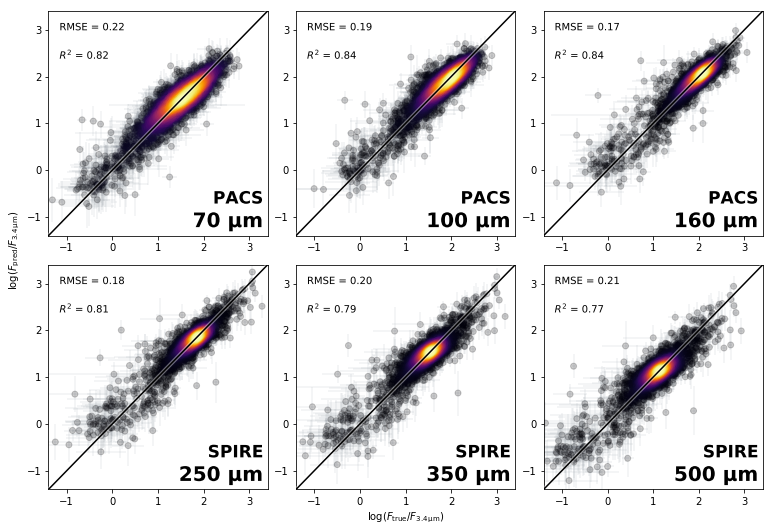

In [16]:
# See paper Fig. 3
from firenet.plotting.truevspred import TrueVSPredPlotter

firbands = d_data['fullbay'].columns[-6:]
idx = y_t.index
y_terr = d_data['fullbayerr'].loc[idx, firbands].divide(d_data['fullbay'].loc[idx] * np.log(10), axis=0)

tvpplot = TrueVSPredPlotter(figsize=(12.8, 8.8))
tvpplot.create_panels(nrows=1)
panel = tvpplot.get_panel(0)
panel.stylized_plot(y_t, y_p, y_terr=y_terr, y_perr=y_perr, 
                    style='firflux')

# Use all (DustPedia + H-ATLAS) data into single model
This model can then be used for other data sets (see notebook `04_predicting.ipynb`)

In [17]:
# Use all data for training and testing (no longer unbiased test set)
idx_tot = d_data['fullbay'].index.values.copy()
np.random.seed(123)
np.random.shuffle(idx_tot)
pred = RegUncPredictor(d_data)
pred.preprocess(idx_train=idx_tot, idx_test=idx_tot)
pred.train_regressor()

  epoch    train_loss    valid_loss    cp     dur
-------  ------------  ------------  ----  ------
      1        0.8316        0.5760     +  0.1003
      2        0.4634        0.3500     +  0.1034
      3        0.3523        0.3015     +  0.0962
      4        0.3187        0.2793     +  0.0988
      5        0.2957        0.2641     +  0.1003
      6        0.2782        0.2522     +  0.1050
      7        0.2656        0.2427     +  0.0992
      8        0.2561        0.2351     +  0.0972
      9        0.2483        0.2287     +  0.1132
     10        0.2416        0.2236     +  0.0979
     11        0.2359        0.2196     +  0.1010
     12        0.2310        0.2168     +  0.0971
     13        0.2269        0.2149     +  0.1049
     14        0.2233        0.2137     +  0.0984
     15        0.2201        0.2133     +  0.0976
     16        0.2174        0.2133     +  0.1019
     17        0.2150        0.2131     +  0.0979
     18        0.2126        0.2115     +  0.0973


In [18]:
pred.train_uncertainty()

  epoch    train_loss    valid_loss    cp     dur
-------  ------------  ------------  ----  ------
      1      213.3418     -159.6854     +  0.1127
      2     -700.7546    -1311.7709     +  0.1158
      3    -1863.9005    -2175.6449     +  0.1204
      4    -2547.2646    -2546.2807     +  0.1102
      5    -2842.1362    -2693.7185     +  0.0957
      6    -2970.5546    -2762.4579     +  0.1057
      7    -3036.7979    -2802.9786     +  0.1193
      8    -3078.0217    -2830.3123     +  0.1223
      9    -3106.9404    -2850.0628     +  0.0998
     10    -3128.4190    -2864.4139     +  0.0961
     11    -3144.9062    -2875.3160     +  0.0969
     12    -3158.1776    -2884.1132     +  0.1042
     13    -3169.1515    -2891.7033     +  0.1018
     14    -3178.4175    -2898.1010     +  0.1021
     15    -3186.3405    -2903.7859     +  0.1033
     16    -3193.2440    -2908.7198     +  0.1019
     17    -3199.3426    -2913.3312     +  0.1129
     18    -3204.6348    -2917.2467     +  0.0973


In [19]:
pred.reg.test(tset='train')

PACS_70      0.203342
PACS_100     0.173601
PACS_160     0.147811
SPIRE_250    0.158982
SPIRE_350    0.174885
SPIRE_500    0.189901
Name: rmse, dtype: float64

In [20]:
ModelStore().store(fspred, name='nnet_alldata')